In [1]:
# Step 1: Setup and Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm, norm, skewnorm
sns.set(style="whitegrid")
np.random.seed(42)
title_font = 18
labels_font = 16
text_font = 14


# How to Report and Judge ML Model Performance: Notebook

This notebook supports the blog post by simulating an imaginary molecular property prediction scenario, focusing on how model performance should be reported. It guides you through:

1. Generating a synthetic chemical space
2. Selecting an *ideal* training dataset
3. Simulating model predictions and residuals
4. Visualizing distribution shapes and expected vs. typical performance
5. Visualizing the confidence in a typical performance
6. Demonstrating performance uncertainty across small test samples


## 1. Simulate the Imaginary Chemical Space of solubility

I want to make an imaginary chemical space that would span all possible aqueous solubility values. So, we will imagine that we have access to molecules with solubility values ranging from 0 molar (i.e., an insoluble molecule -e.g., lead-) to 1 molar (i.e., a fully soluble molecule -e.g., salt-).

If we assume this space to follow a normal distribution, as heavily assumed in many places in our lives, we would expect the peak of the distribution to be at 0.5 molar. And just as a standard normal distribution, the deviation from this `mean` is expected to span 3 strides on each side of[^1]. 

I will be reporting solubility in micro molar (µM), so that the values on the x-axis will be easily read as integers rather than fractions if reported in molar. We already know from the first blog post that our brains are not that great with decimals anyway 😉 

In [2]:
from matplotlib.ticker import FuncFormatter

# tick formatter (K / M for both axes)
def fmt_tick(val, _):
    if val >= 1_000_000:
        return f'{val/1_000_000:.0f}M'
    if val >= 1_000:
        return f'{val/1_000:.0f}K'
    return f'{val:.0f}'

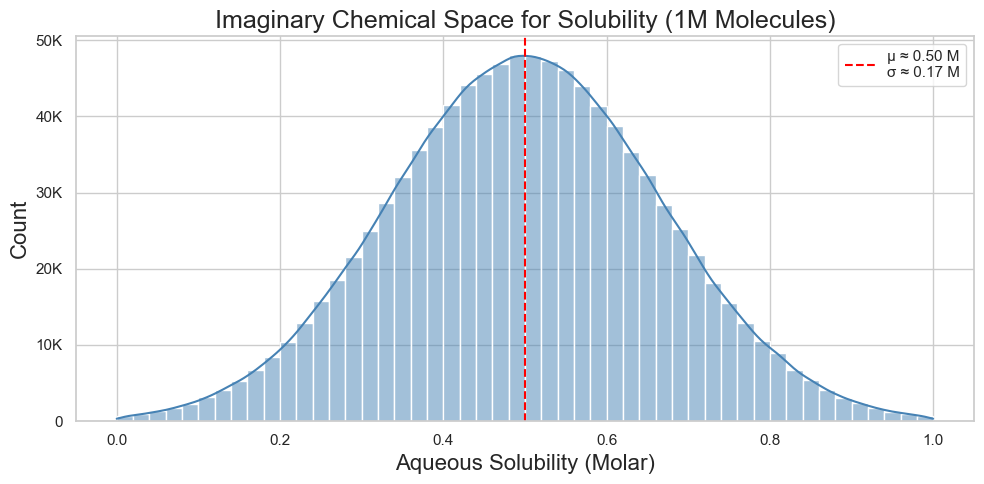

In [3]:
# ---------- parameters ----------
N       = 1_000_000             # number of molecules
lower   = 0                     # µM
upper   = 1                     # µM
mu      = (upper + lower) / 2   
sigma   = (upper - lower) / 6   

# ---------- draw from truncated normal ----------
a, b = (lower - mu) / sigma, (upper - mu) / sigma   # −3, +3
population = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=N)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(population, bins=50, kde=True, color='steelblue', ax=ax)

# red dashed line at realised mean
ax.axvline(population.mean(), color='red', linestyle='--',
           label=f'μ ≈ {mu:.2f} M\nσ ≈ {sigma:.2f} M')

#ax.xaxis.set_major_formatter(FuncFormatter(fmt_tick))
ax.yaxis.set_major_formatter(FuncFormatter(fmt_tick))

ax.set_title(f"Imaginary Chemical Space for Solubility ({fmt_tick(N, _)} Molecules)", fontsize=title_font)
ax.set_xlabel("Aqueous Solubility (Molar)", fontsize=labels_font)
ax.set_ylabel("Count", fontsize=labels_font)
ax.legend()
plt.tight_layout()
plt.show()


## 2. Create an Ideal Training Dataset

Now, if we want to train a model to understand and predict the concept of solubility (i.e., a model that will know when and why a molecule will be soluble with 0.1 molar or 0.9 molar), then we need to show the model enough samples from each range. By doing so, the model will extract general similarities and differences that will characterize each range of solubility. 

What we have just described is called **Uniform Distribution**. And I assure you, you will probably never see it in real like. But here, we are imagining, so, let's make the imagination as wild as can be!

/var/folders/73/c3m40qq90r7g0_s26wvg817m0000gn/T/ipykernel_16332/3184912861.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_bin, random_state=42)


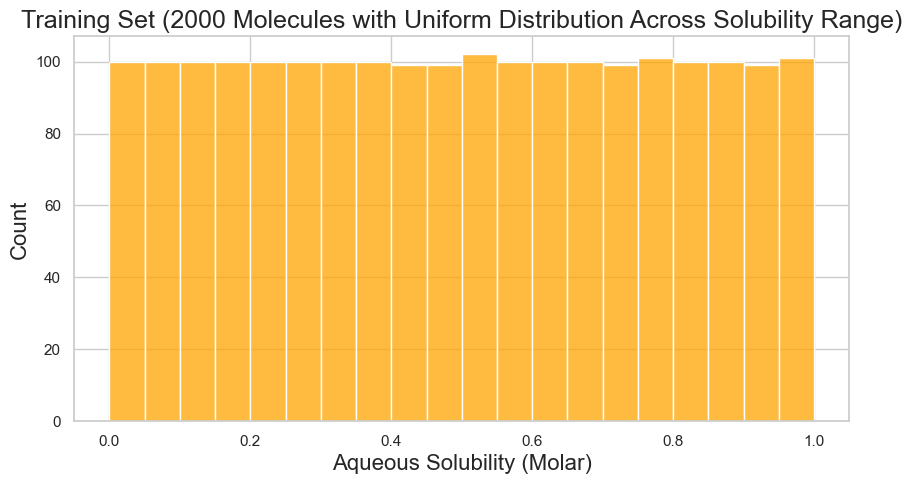

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_sample = 2000
n_bins = 20
samples_per_bin = n_sample // n_bins  # ensures an integer (100)

# Create bin edges (21 edges for 20 bins)
bins = np.linspace(lower, upper, n_bins + 1)

# Assign each value to a bin (0-indexed)
bin_indices = np.digitize(population, bins) - 1

# Build a DataFrame for stratified sampling
pop_df = pd.DataFrame({'value': population, 'bin': bin_indices})

# Stratified sampling: take equal samples from each bin (if enough values exist)
train_sample = (
    pop_df
    .groupby('bin')
    .apply(lambda x: x.sample(n=samples_per_bin, random_state=42)
           if len(x) >= samples_per_bin else x)
    .reset_index(drop=True)['value']
    .values
)

# Plot histogram of sampled training set
plt.figure(figsize=(10, 5))
sns.histplot(train_sample, bins=n_bins, kde=False, color='orange')
ax.xaxis.set_major_formatter(FuncFormatter(fmt_tick))
plt.title("Training Set (2000 Molecules with Uniform Distribution Across Solubility Range)", fontsize=title_font)
plt.xlabel("Aqueous Solubility (Molar)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.show()

### 2.1 Overlay the Training Set on the Population

This visualization highlights how the training set samples from across the chemical space.


/Users/afnan_sultan/miniconda3/envs/emtrl_datasail/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


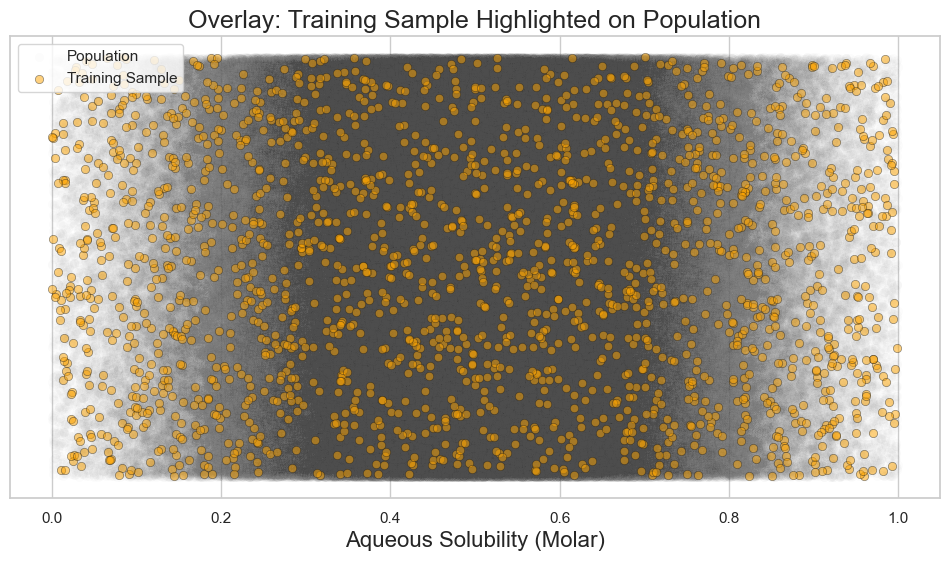

In [5]:
plt.figure(figsize=(12, 6))
y = np.zeros_like(population)
y_sample = np.zeros_like(train_sample)

# Add jitter to y-values for visibility
y += np.random.uniform(-0.1, 0.1, size=len(population))
y_sample += np.random.uniform(-0.1, 0.1, size=len(train_sample))

# Scatter plots with edgecolors for visible legend borders
plt.scatter(population, y, alpha=0.02, label="Population",
            color="grey", edgecolors='k', linewidths=0.2)

plt.scatter(train_sample, y_sample, alpha=0.5, label="Training Sample",
            color="orange", edgecolors='k', linewidths=0.5)

plt.title("Overlay: Training Sample Highlighted on Population", fontsize=title_font)
plt.xlabel("Aqueous Solubility (Molar)", fontsize=labels_font)
plt.yticks([])
plt.legend()
plt.show()


## 3. Simulate Test Predictions

In the post, we argue that when you predict your trained model on new molecules that your chemist is interested at, your model's precautions will follow a distribution, and from these predictions, we can estimate the expected error of our model. 

So, let's select 200 molecules from our solubility chemical space and imagine that they are the molecules that our chemist is interested in. 

In [6]:
# Select test set
test_size = 400
test_true = np.random.choice(population, size=test_size, replace=False)

We already know the true values of this test set, but you can be confident that when your model predict these values, it will never be 100% accurate. There will always be predictions that are very close or very far. 

Since we are not training an actual model, we will just simulate this error (i.e., residual). We will assume that it follows a normal distribution with peak at 0 (i.e., the majority of predictions are correct) and the rest of the predictions will be either over- or under-predicted. We will cal this model, `Model A`. 

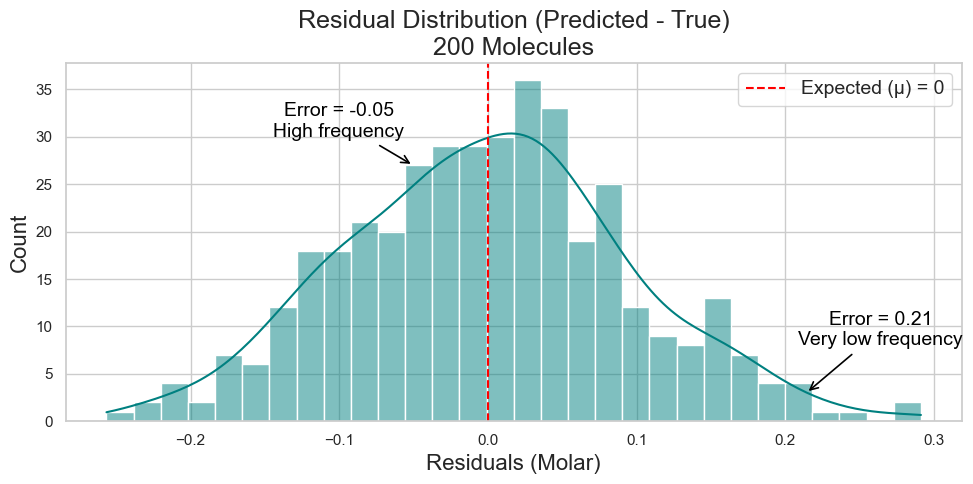

In [7]:
# Simulate predictions
rng = np.random.default_rng(42)
mu_A = 0
sigma_A = 0.1
noise_A = rng.normal(mu_A, sigma_A, size=test_size)
test_pred_A = test_true + noise_A
residuals_A = test_pred_A - test_true  # Same as noise, this is how error is calculated in real ML application

# Plot residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals_A, bins=30, kde=True, color='teal')

# Mean line
plt.axvline(mu_A, color='red', linestyle='--', label=f'Expected (µ) = {mu_A}')

# Tail values
high = np.percentile(residuals_A, 29)
right_tail = np.percentile(residuals_A, 99)

plt.annotate(f'Error = {high:.2f}\nHigh frequency', xy=(high, 27), xytext=(high - 0.05, 30),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
             fontsize=text_font, color='black', ha='center')

plt.annotate(f'Error = {right_tail:.2f}\nVery low frequency', xy=(right_tail, 3), xytext=(right_tail + 0.05, 8),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
             fontsize=text_font, color='black', ha='center')

plt.title("Residual Distribution (Predicted - True)\n200 Molecules", fontsize=title_font)
plt.xlabel("Residuals (Molar)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.legend(fontsize=text_font)
plt.tight_layout()
plt.show()


## 4. Visualize Expected vs. Typical Values in Different Distributions

We took a detour in the blog post to talk about what is expected and what is typical. the `Espected` value is what we hope the distribution would converge to eventually, and this concept is very rooted in normal distribution. However, what is `Typical`(i.e., the most likely value to show up in a distribution) can vary drastically from the `Expected` depending on the distribution shape. 

Below, we visualize four different distributions to see how the expected and typical values differ.


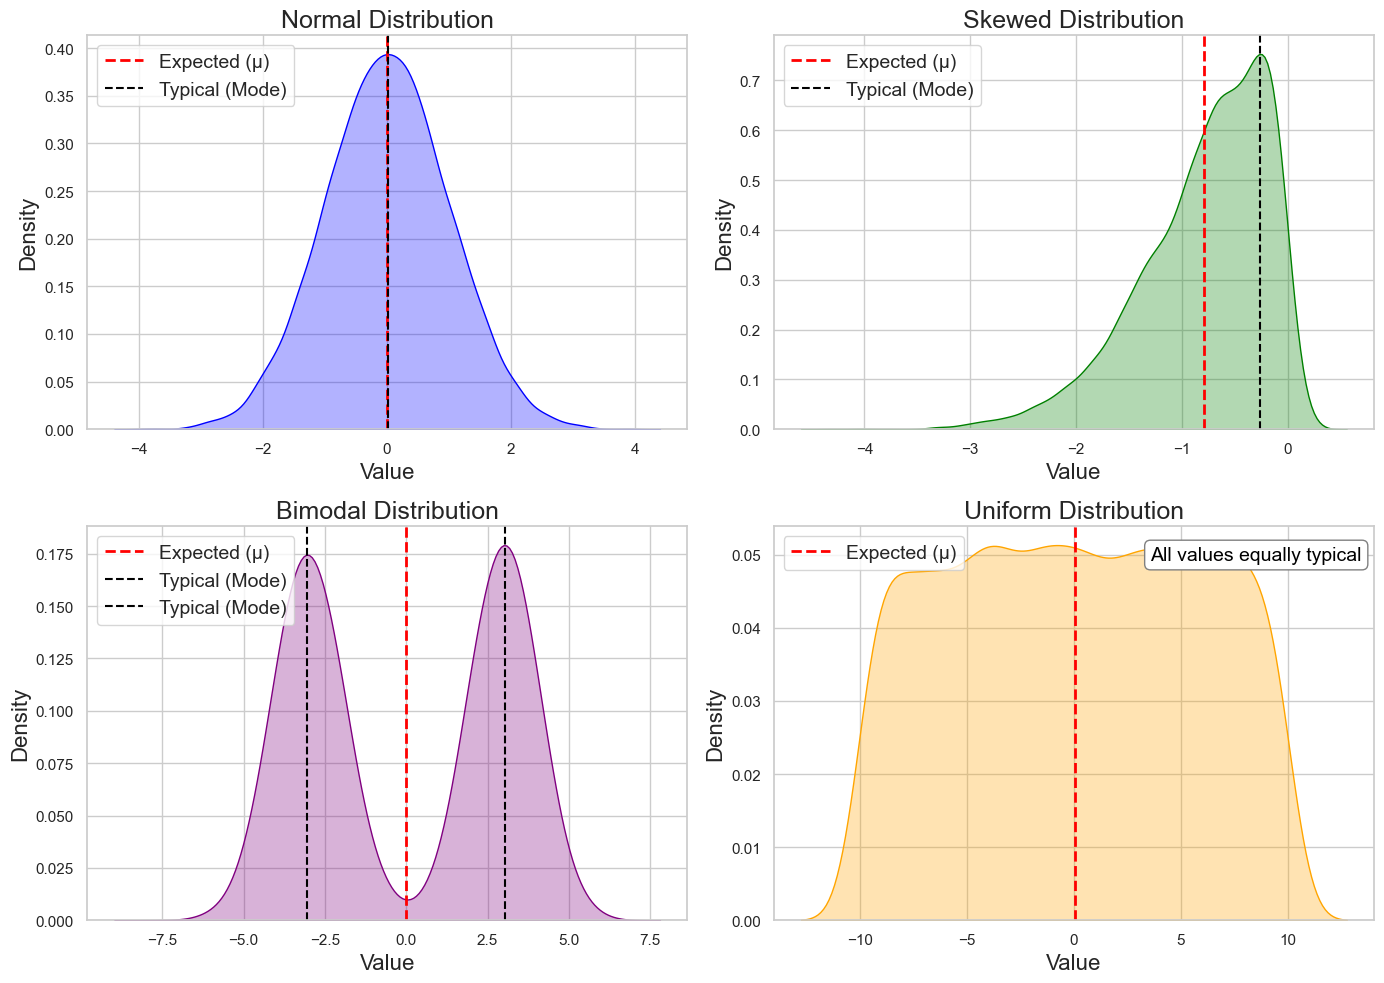

In [8]:
# Set seed for reproducibility
np.random.seed(42)

size = 10000

# Normal distribution data
mu_normal = 0
sigma_normal = 1
normal_data = norm(loc=mu_normal, scale=sigma_normal).rvs(size=size)

# Skewed distribution data
mu_skewed = 0
sigma_skewed = 1
skewed_data = skewnorm(a=-10, loc=mu_skewed, scale=sigma_skewed).rvs(size=size)

# Bimodal distribution data
mode_1, sigma_1 = -3, 1
mode_2, sigma_2 = 3, 1
bimodal_data = np.concatenate([
    norm(loc=mode_1, scale=sigma_1).rvs(size=size//2),
    norm(loc=mode_2, scale=sigma_2).rvs(size=size//2)
])

# Uniform distribution data
uniform_data = np.random.uniform(low=-10, high=10, size=size)

from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Function to find one or more modes using KDE and peak detection
def get_modes(data, data_size, num_peaks=2, distance=50):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), data_size)
    y_kde = kde(x_grid)
    peaks, _ = find_peaks(y_kde, distance=distance)
    peak_xs = x_grid[peaks]
    sorted_peaks = peak_xs[np.argsort(-y_kde[peaks])]
    return sorted_peaks[:num_peaks]

# List of distributions and their data
distributions = [
    ("Normal Distribution", normal_data, np.mean(normal_data), get_modes(normal_data, size, 1), "blue"),
    ("Skewed Distribution", skewed_data, np.mean(skewed_data), get_modes(skewed_data, size, 1), "green"),
    ("Bimodal Distribution", bimodal_data, np.mean(bimodal_data), get_modes(bimodal_data, size, 2), "purple"),
    ("Uniform Distribution", uniform_data, np.mean(uniform_data), None, "orange")
]

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for ax, (title, data, mean, modes, color) in zip(axs.flatten(), distributions):
    sns.kdeplot(data, ax=ax, color=color, fill=True, alpha=0.3)
    ax.set_title(title, fontsize=title_font)
    ax.set_xlabel("Value", fontsize=labels_font)
    ax.yaxis.label.set_fontsize(labels_font)

    ax.axvline(mean, color='red', linestyle='--', lw=2, label="Expected (µ)")

    if title == "Uniform Distribution":
        ax.text(
            0.98, 0.95,  # x, y in axis fraction (top right corner)
            "All values equally typical",
            transform=ax.transAxes,  # interpret position in axis coords
            ha='right', va='top',  # align text box to the top-right corner
            fontsize=text_font,
            color='black',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray'),
        )

    else:
        for mode in modes:
            ax.axvline(mode, color='black', linestyle='--', label='Typical (Mode)')
            
    ax.legend(loc='upper left', fontsize=text_font)

plt.tight_layout()
plt.show()


## 5. Model Stability

After discussing which value to report as the model's error, and going with the `Typical` value, we moved to the concept of confidence in this value. One value is not enough to describe a distribution, it only gives you an idea on where **most** of the values lie. But what is the definition of this "**most**"? It can be 90%, and it can be 40%, this information matters! And this information can be obtained from reporting the standard deviation (σ). 

We already imagined that we trained `Model A`and we showed its distribution above. Now, let's imagine that we trained another model called `Model B`. This model has the same typical error as model A, but the spread around this value is wider. 

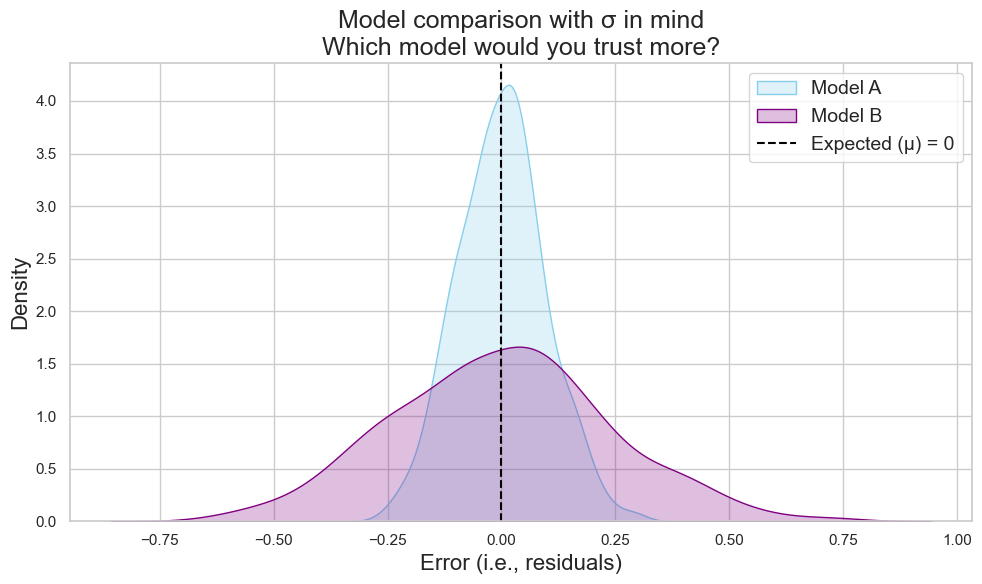

In [9]:
mu_B = mu_A
sigma_B = 0.25
rng = np.random.default_rng(42)
noise_B = rng.normal(mu_B, sigma_B, size=test_size)
test_pred_B = test_true + noise_B
residuals_B = test_pred_B - test_true  # Same as noise, this is how error is calculated in real ML application

plt.figure(figsize=(10, 6)) 
colors = ['skyblue', 'purple']
for i, (model_name, predicted_sample) in enumerate({'Model A': residuals_A, 'Model B': residuals_B}.items()):
    sns.kdeplot(predicted_sample, label=model_name, color=colors[i], fill=True)
    if i == 1:
        plt.axvline(mu_A, color='black', linestyle='--', label=f'Expected (µ) = {mu_A}')


plt.title("Model comparison with σ in mind\nWhich model would you trust more?", fontsize=title_font)
plt.xlabel("Error (i.e., residuals)", fontsize=labels_font)
plt.ylabel("Density", fontsize=labels_font)
plt.legend(loc='upper right', fontsize=text_font)
plt.tight_layout()
plt.show()

## 6. Sampling Uncertainty

We finish the blog post by talking about sampling uncertainty. We imagined that we split our training data into 80:20 train-test ratio, and we tested our model on 400 molecules that it has not seen before. Then we argued that 400 is a low number to establish high confidence in the typical value. This confidence can be attained only from testing on a HUGE representative testing sample. 

Below, I will walk you through this requirement visually to see how a small test sample can be divergent from the true typical performance of the model after being tested on 10s of thousands of new molecules. 


## Gold Standard

Let's go back to our solubility chemical space population and retrieve 10 thousand values from there. We will consider this set as the `Gold Standard Test`. It is a set of huge number of solubility values that, when predicted by a model, would be guaranteed to give the most confident estimate of this model's typical error. 


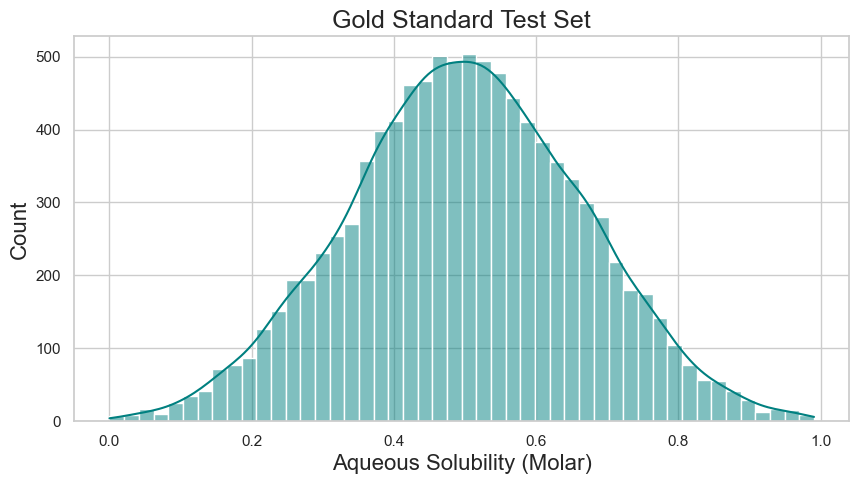

In [10]:
gold_standard_test_size = 10000
gold_standard_true = np.random.choice(population, size=gold_standard_test_size, replace=False)

# Plot histogram of Gold Standard Test set
plt.figure(figsize=(10, 5))
sns.histplot(gold_standard_true, kde=True, color='teal')

plt.title("Gold Standard Test Set", fontsize=title_font)
plt.xlabel("Aqueous Solubility (Molar)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.show()

## Model performance on Gold Standard
Now, let's imagine that our model hs provided predictions for these 10k molecules, and the residuals had the following distribution

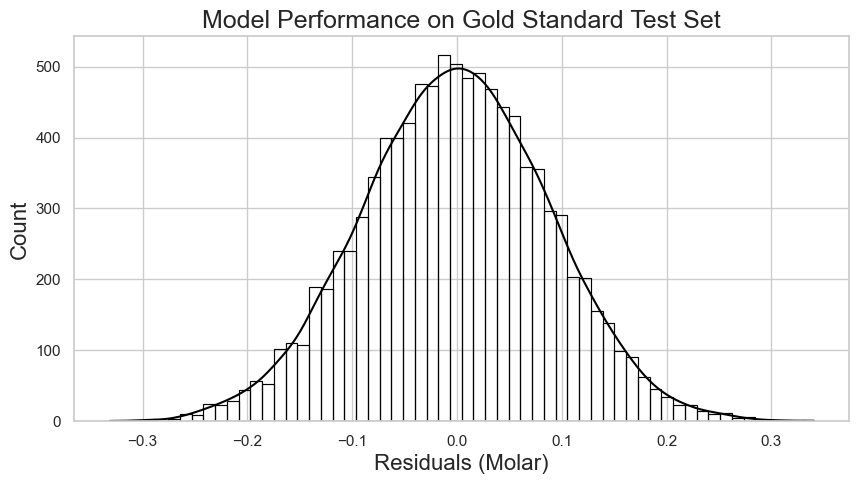

In [11]:
mu_gold_error = 0
sigma_gold_error = 0.09
gold_standard_pred = gold_standard_true + np.random.normal(loc=mu_gold_error, scale=sigma_gold_error, size=len(gold_standard_true))
model_true_performance = gold_standard_pred - gold_standard_true

# Plot histogram of Gold Standard Test set
plt.figure(figsize=(10, 5))
sns.histplot(model_true_performance, kde=True, color='black', fill=False)

plt.title("Model Performance on Gold Standard Test Set", fontsize=title_font)
plt.xlabel("Residuals (Molar)", fontsize=labels_font)
plt.ylabel("Count", fontsize=labels_font)
plt.show()

## Model Performance on small test sets

Finally, we will simulate the performance of our model on 10 small test set varying in sizes between 200 and 600 molecules. We will use different levels of noise ranging from minor to major noise. If a sample shows too small noise (i.e., residuals), it means that the sample was quite easy for the model to predict. If it showed too high noise, then it was very hard for the model. And if it showes similar noise level as for the gold standard, then the sample was representative of this gold standard.

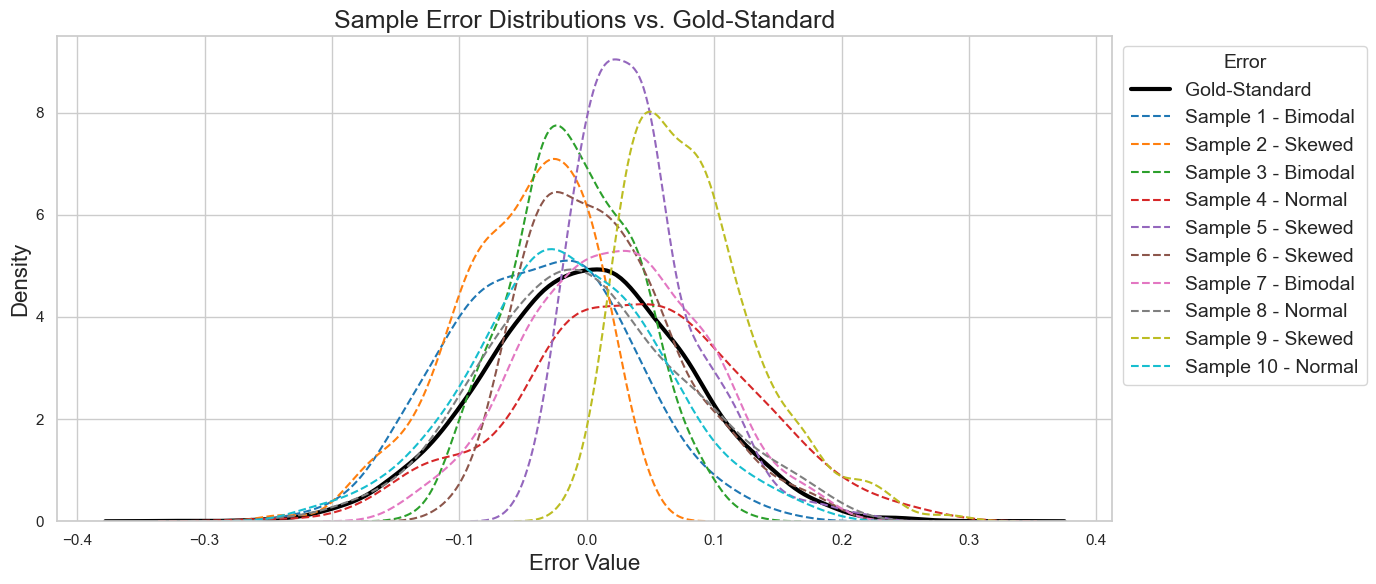

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm, skewnorm

np.random.seed(40)

num_samples = 10
sample_size = 400
value_bounds = (-0.34, 0.34)
mean_bounds = (-0.05, 0.05)

# Simulate a gold-standard true performance set
model_true_performance = np.random.normal(loc=0.0, scale=0.08, size=10000)
model_true_performance = np.clip(model_true_performance, *value_bounds)

samples = []
labels = []

for i in range(num_samples):
    # Randomly select a mean within [-0.05, 0.05]
    mean = np.random.uniform(mean_bounds[0], mean_bounds[1])
    
    # Randomly decide distribution type
    dist_type = np.random.choice(['normal', 'skewed', 'bimodal'])

    if dist_type == 'normal':
        scale = np.random.uniform(0.05, 0.1)
        a, b = (value_bounds[0] - mean) / scale, (value_bounds[1] - mean) / scale
        data = truncnorm(a, b, loc=mean, scale=scale).rvs(sample_size)
        label = f"Sample {i+1} - Normal"

    elif dist_type == 'skewed':
        skew = np.random.choice([-5, -3, 3, 5])
        scale = np.random.uniform(0.05, 0.1)
        data = skewnorm(a=skew, loc=mean, scale=scale).rvs(sample_size)
        data = np.clip(data, *value_bounds)
        label = f"Sample {i+1} - Skewed"

    else:  # bimodal
        offset = np.random.uniform(0.05, 0.1)
        mean1 = mean - offset / 2
        mean2 = mean + offset / 2
        scale = np.random.uniform(0.03, 0.06)
        a1, b1 = (value_bounds[0] - mean1) / scale, (value_bounds[1] - mean1) / scale
        a2, b2 = (value_bounds[0] - mean2) / scale, (value_bounds[1] - mean2) / scale
        half = sample_size // 2
        data1 = truncnorm(a1, b1, loc=mean1, scale=scale).rvs(half)
        data2 = truncnorm(a2, b2, loc=mean2, scale=scale).rvs(sample_size - half)
        data = np.concatenate([data1, data2])
        label = f"Sample {i+1} - Bimodal"

    samples.append(data)
    labels.append(label)

# Plotting all generated samples over gold-standard
plt.figure(figsize=(14, 6))
sns.kdeplot(model_true_performance, label="Gold-Standard", linewidth=3, color='black')

colors = plt.cm.tab10(np.linspace(0, 1, num_samples))
for i, (sample, label) in enumerate(zip(samples, labels)):
    sns.kdeplot(sample, label=label, linestyle='--', color=colors[i])

plt.title("Sample Error Distributions vs. Gold-Standard", fontsize=title_font)
plt.xlabel("Error Value", fontsize=labels_font)
plt.ylabel("Density", fontsize=labels_font)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title="Error", title_fontsize=text_font, fontsize=text_font)
plt.tight_layout()
plt.show()


## Summary

- Residuals represent model prediction noise and should be treated as distributions.
- The expected error (mean) may not reflect the typical case (mode).
- Small test sets and variable model stability lead to widely varying residuals.
- The most honest evaluation comes from understanding the shape, spread, and source of your reported performance metrics.


[^1]: More about normal distribution will come later. And many of the 'let's just say it this way' introduced language, shall become clearer later. 